In [28]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

# Data preparation

In [29]:
df = pd.read_csv('air_dataset.csv')
df.drop(columns='Unnamed: 0',inplace=True)
class_name = 'weekend'

In [30]:
df.head()

,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,0,1186.50
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,0,1148.75
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,0,1024.50
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,0,1015.00
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,0,883.25


In [31]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [32]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [33]:
res = prepare_dataset(df, class_name)
df.head()

C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,0,1186.50
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,0,1148.75
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,0,1024.50
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,0,1015.00
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,0,883.25


# Data partitioning

In [34]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, precision_score

In [35]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

# Sklearn Multilayer Perceptron

In [36]:
from sklearn.neural_network import MLPClassifier

### Parameters

hidden_layer_sizes tuple, length = n_layers - 2, default=(100,)
The ith element represents the number of neurons in the ith hidden layer.

activation {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
Activation function for the hidden layer.
* 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x
* 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
* 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).
* 'relu', the rectified linear unit function, returns f(x) = max(0, x)

solver {'lbfgs', 'sgd', 'adam'}, default='adam'
The solver for weight optimization.
* 'lbfgs' is an optimizer in the family of quasi-Newton methods.
* 'sgd' refers to stochastic gradient descent.
* 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
The default solver 'adam' works pretty well on relatively large datasets (>= 1000 training samples) in terms of both training time and validation score. For small datasets, 'lbfgs' can converge faster and perform better.

alpha float, default=0.0001
L2 penalty (regularization term) parameter.

batch_size int, default='auto'
Size of minibatches for stochastic optimizers. If the solver is 'lbfgs', the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples)

learning_rate {'constant', 'invscaling', 'adaptive'}, default='constant'
Learning rate schedule for weight updates.
*'constant' is a constant learning rate given by 'learning_rate_init'.
*'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of *'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)
*'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.
Only used when solver='sgd'.

learning_rate_init double, default=0.001
The initial learning rate used. It controls the step-size in updating the weights. Only used when solver='sgd' or 'adam'.

power_t double, default=0.5
The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to 'invscaling'. Only used when solver='sgd'.

max_iter int, default=200
Maximum number of iterations. The solver iterates until convergence (determined by 'tol') or this number of iterations. For stochastic solvers ('sgd', 'adam'), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

shuffle bool, default=True
Whether to shuffle samples in each iteration. Only used when solver='sgd' or 'adam'.

random_state int, RandomState instance or None, default=None
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

tol float, default=1e-4
Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to 'adaptive', convergence is considered to be reached and training stops.

verbose bool, default=False
Whether to print progress messages to stdout.

warm_start bool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. See the Glossary.

momentum float, default=0.9
Momentum for gradient descent update. Should be between 0 and 1. Only used when solver='sgd'.

early_stopping bool, default=False
Whether to use early stopping to terminate training when validation score is not improving. If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. Only effective when solver='sgd' or 'adam'

validation_fraction float, default=0.1
The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True

beta_1 float, default=0.9
Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver='adam'

beta_2 float, default=0.999
Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver='adam'

epsilon float, default=1e-8
Value for numerical stability in adam. Only used when solver='adam'

n_iter_no_change int, default=10
Maximum number of epochs to not meet tol improvement. Only effective when solver='sgd' or 'adam'


### Attributes
loss_ float
The current loss computed with the loss function.

coefs_ list, length n_layers - 1
The ith element in the list represents the weight matrix corresponding to layer i.

intercepts_ list, length n_layers - 1
The ith element in the list represents the bias vector corresponding to layer i + 1.

n_iter_ int,
The number of iterations the solver has ran.

n_layers_ int
Number of layers.

n_outputs_ int
Number of outputs.

out_activation_ string
Name of the output activation function.

In [68]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32,), alpha=0.1, learning_rate='adaptive', 
                    activation='tanh', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7735042735042735
Precision 0.6469072164948454
Recall 0.46654275092936803
F1-score [0.84953868 0.54211663]
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1334
           1       0.65      0.47      0.54       538

    accuracy                           0.77      1872
   macro avg       0.73      0.68      0.70      1872
weighted avg       0.76      0.77      0.76      1872



C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Gridsearch

In [38]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [57]:
# ci mette troppo tempo. non rifare
parameters = {'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(100,1), (100,2), (100,3)],
'activation': ["logistic", "relu", "Tanh","adam"], 'alpha': 10.0 ** -np.arange(1, 10),}

mlpc = MLPClassifier()
search = GridSearchCV(mlpc, parameters,cv = 4)
search.fit(X_train, y_train)
report(search.cv_results_, n_top=3)

"""
RISULTATO:

Model with rank: 1
Mean validation score: 0.766 (std: 0.004)
Parameters: {'activation': 'relu', 'alpha': 1e-09, 'hidden_layer_sizes': (100, 3), 'learning_rate': 'constant'}

Model with rank: 2
Mean validation score: 0.766 (std: 0.003)
Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 3), 'learning_rate': 'invscaling'}

Model with rank: 3
Mean validation score: 0.765 (std: 0.005)
Parameters: {'activation': 'relu', 'alpha': 1e-09, 'hidden_layer_sizes': (100, 2), 'learning_rate': 'constant'}
"""

C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Max

Model with rank: 1
Mean validation score: 0.766 (std: 0.004)
Parameters: {'activation': 'relu', 'alpha': 1e-09, 'hidden_layer_sizes': (100, 3), 'learning_rate': 'constant'}

Model with rank: 2
Mean validation score: 0.766 (std: 0.003)
Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 3), 'learning_rate': 'invscaling'}

Model with rank: 3
Mean validation score: 0.765 (std: 0.005)
Parameters: {'activation': 'relu', 'alpha': 1e-09, 'hidden_layer_sizes': (100, 2), 'learning_rate': 'constant'}



C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [58]:
clf = search.best_estimator_
clf

MLPClassifier(activation='relu', alpha=1e-09, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 3), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [59]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7558760683760684
Precision 0.5966587112171837
Recall 0.4646840148698885
F1-score [0.8360244  0.52246604]
              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1334
           1       0.60      0.46      0.52       538

    accuracy                           0.76      1872
   macro avg       0.70      0.67      0.68      1872
weighted avg       0.74      0.76      0.75      1872



C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[1165,  169],
       [ 288,  250]], dtype=int64)

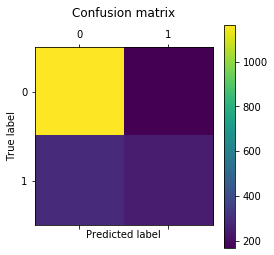

In [60]:
plt.matshow(cm)
plt.title('Confusion matrix\n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [61]:
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)

0.6689986790991121


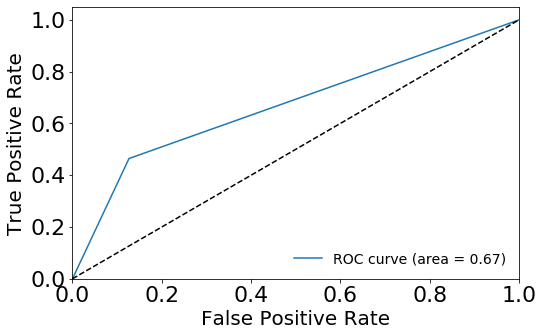

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

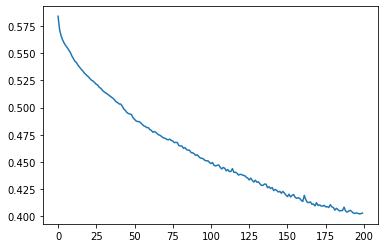

In [63]:
plt.plot(clf.loss_curve_)
plt.show()

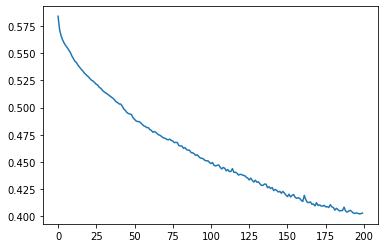

In [64]:
plt.plot(clf.loss_curve_)
plt.show()

In [65]:
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum", "adam"]

In [66]:
import warnings
from sklearn.exceptions import ConvergenceWarning

constant learning-rate
training set score and loss: 0.780, 0.440162


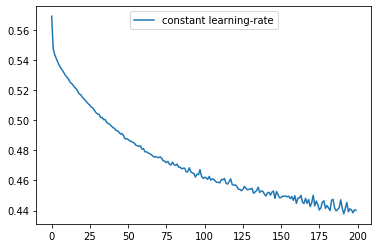

constant with momentum
training set score and loss: 0.786, 0.429960


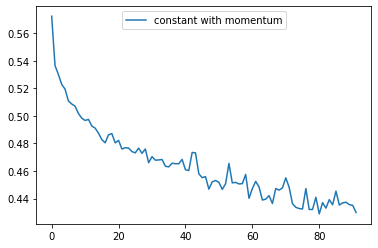

inv-scaling learning-rate
training set score and loss: 0.724, 0.549289


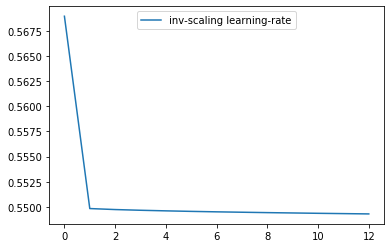

inv-scaling with momentum
training set score and loss: 0.723, 0.534876


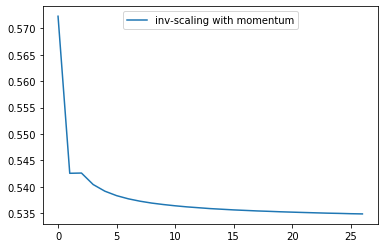

adam
training set score and loss: 0.817, 0.395375


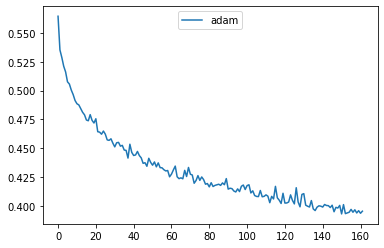

In [67]:
for label, param in zip(labels, params):
    print(label)
    clf = MLPClassifier(random_state=0, max_iter=200, **param)

    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X, y)

    print("training set score and loss: %.3f, %f" % (clf.score(X, y), clf.loss_))
    plt.plot(clf.loss_curve_, label=label)
    plt.legend(loc="upper center")
    plt.show()

# Keras Deep Neural Networks

In [69]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [70]:
def build_model():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [71]:
model1 = build_model()

history1 = model1.fit(X_train, y_train, epochs=50, batch_size=10).history

Epoch 1/50
7485/7485 [==============================] - 1s 154us/step - loss: 0.5418 - accuracy: 0.7232
Epoch 2/50
7485/7485 [==============================] - 1s 98us/step - loss: 0.5239 - accuracy: 0.7276
Epoch 3/50
7485/7485 [==============================] - 1s 106us/step - loss: 0.5078 - accuracy: 0.7405
Epoch 4/50
7485/7485 [==============================] - 1s 102us/step - loss: 0.4976 - accuracy: 0.7413
Epoch 5/50
7485/7485 [==============================] - 1s 111us/step - loss: 0.4860 - accuracy: 0.7502
Epoch 6/50
7485/7485 [==============================] - 1s 117us/step - loss: 0.4777 - accuracy: 0.7515
Epoch 7/50
7485/7485 [==============================] - 1s 100us/step - loss: 0.4742 - accuracy: 0.7523
Epoch 8/50
7485/7485 [==============================] - 1s 92us/step - loss: 0.4648 - accuracy: 0.7605
Epoch 9/50
7485/7485 [==============================] - 1s 84us/step - loss: 0.4625 - accuracy: 0.7647
Epoch 10/50
7485/7485 [==============================] - 1s 97us/st

In [75]:
model2 = build_model()

history2 = model2.fit(X_train, y_train, epochs=50, batch_size=50).history

Epoch 1/50
7485/7485 [==============================] - 1s 67us/step - loss: 0.5520 - accuracy: 0.7173
Epoch 2/50
7485/7485 [==============================] - 0s 32us/step - loss: 0.5301 - accuracy: 0.7252
Epoch 3/50
7485/7485 [==============================] - 0s 33us/step - loss: 0.5211 - accuracy: 0.7281
Epoch 4/50
7485/7485 [==============================] - 0s 36us/step - loss: 0.5125 - accuracy: 0.7316
Epoch 5/50
7485/7485 [==============================] - 0s 38us/step - loss: 0.5029 - accuracy: 0.7391
Epoch 6/50
7485/7485 [==============================] - 0s 44us/step - loss: 0.4978 - accuracy: 0.7427
Epoch 7/50
7485/7485 [==============================] - 0s 45us/step - loss: 0.4923 - accuracy: 0.7475
Epoch 8/50
7485/7485 [==============================] - 0s 36us/step - loss: 0.4874 - accuracy: 0.7504
Epoch 9/50
7485/7485 [==============================] - 0s 51us/step - loss: 0.4812 - accuracy: 0.7560
Epoch 10/50
7485/7485 [==============================] - 0s 41us/step - l

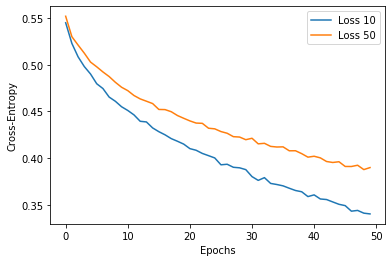

In [76]:
plt.plot(history1['loss'], label='Loss 10')
plt.plot(history2['loss'], label='Loss 50')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [77]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

1872/1872 [==============================] - 0s 36us/step
Loss 0.487981, Accuracy 0.774038
Loss 0.467671, Accuracy 0.769765


In [78]:
y_pred = model1.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7126068376068376
F1-score [0.83218964 0.        ]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1334
           1       0.00      0.00      0.00       538

    accuracy                           0.71      1872
   macro avg       0.36      0.50      0.42      1872
weighted avg       0.51      0.71      0.59      1872



C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
model3 = build_model()

history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=10).history

Train on 7485 samples, validate on 1872 samples
Epoch 1/1000
7485/7485 [==============================] - 1s 167us/step - loss: 0.5458 - accuracy: 0.7196 - val_loss: 0.5455 - val_accuracy: 0.7217
Epoch 2/1000
7485/7485 [==============================] - 1s 146us/step - loss: 0.5256 - accuracy: 0.7276 - val_loss: 0.5346 - val_accuracy: 0.7158
Epoch 3/1000
7485/7485 [==============================] - 1s 107us/step - loss: 0.5130 - accuracy: 0.7320 - val_loss: 0.5248 - val_accuracy: 0.7260
Epoch 4/1000
7485/7485 [==============================] - 1s 114us/step - loss: 0.4984 - accuracy: 0.7454 - val_loss: 0.5124 - val_accuracy: 0.7340
Epoch 5/1000
7485/7485 [==============================] - 1s 118us/step - loss: 0.4892 - accuracy: 0.7478 - val_loss: 0.5156 - val_accuracy: 0.7260
Epoch 6/1000
7485/7485 [==============================] - 1s 126us/step - loss: 0.4819 - accuracy: 0.7488 - val_loss: 0.5069 - val_accuracy: 0.7366
Epoch 7/1000
7485/7485 [==============================] - 1s 102

In [80]:
test_loss_3, test_acc_3 = model3.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))

1872/1872 [==============================] - 0s 16us/step
Loss 0.487981, Accuracy 0.774038
Loss 0.467671, Accuracy 0.769765
Loss 1.729832, Accuracy 0.800748


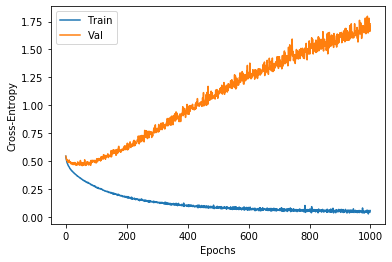

In [81]:
plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [82]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Early Stopping

In [83]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

The most relevant arguments are:

* monitor: quantity to be monitored
* patience: number of epochs with no improvement after which training will be stopped

In [85]:
es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

model4 = build_model()
history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                      batch_size=10, callbacks=[es,mc]).history

Train on 5988 samples, validate on 1497 samples
Epoch 1/100
5988/5988 [==============================] - 1s 191us/step - loss: 0.5462 - accuracy: 0.7201 - val_loss: 0.5251 - val_accuracy: 0.7395
Epoch 2/100
5988/5988 [==============================] - 1s 120us/step - loss: 0.5269 - accuracy: 0.7226 - val_loss: 0.5182 - val_accuracy: 0.7348
Epoch 3/100
5988/5988 [==============================] - 1s 144us/step - loss: 0.5149 - accuracy: 0.7311 - val_loss: 0.5017 - val_accuracy: 0.7408
Epoch 4/100
5988/5988 [==============================] - 1s 143us/step - loss: 0.5049 - accuracy: 0.7395 - val_loss: 0.4907 - val_accuracy: 0.7482
Epoch 5/100
5988/5988 [==============================] - 1s 130us/step - loss: 0.4973 - accuracy: 0.7450 - val_loss: 0.4815 - val_accuracy: 0.7488
Epoch 6/100
5988/5988 [==============================] - 1s 120us/step - loss: 0.4870 - accuracy: 0.7458 - val_loss: 0.4901 - val_accuracy: 0.7448
Epoch 7/100
5988/5988 [==============================] - 1s 131us/step

In [86]:
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
print('Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))

1872/1872 [==============================] - 0s 19us/step
Loss 0.487981, Accuracy 0.774038
Loss 0.467671, Accuracy 0.769765
Loss 1.729832, Accuracy 0.800748
Loss 0.506051, Accuracy 0.766026


# L2 Regularization

In [87]:
from keras.regularizers import l2

def build_L2_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,), kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [88]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_loss', save_best_only=True)

L2_model = build_L2_model()
h_L2 = L2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                    batch_size=10, callbacks=[es,mc]).history

Train on 5988 samples, validate on 1497 samples
Epoch 1/100
5988/5988 [==============================] - 2s 274us/step - loss: 1.7968 - accuracy: 0.7017 - val_loss: 1.1064 - val_accuracy: 0.7401
Epoch 2/100
5988/5988 [==============================] - 1s 167us/step - loss: 0.9127 - accuracy: 0.7111 - val_loss: 0.7684 - val_accuracy: 0.7328
Epoch 3/100
5988/5988 [==============================] - 1s 231us/step - loss: 0.7076 - accuracy: 0.7166 - val_loss: 0.6398 - val_accuracy: 0.7361
Epoch 4/100
5988/5988 [==============================] - 1s 183us/step - loss: 0.6345 - accuracy: 0.7164 - val_loss: 0.6013 - val_accuracy: 0.7288
Epoch 5/100
5988/5988 [==============================] - 1s 158us/step - loss: 0.5999 - accuracy: 0.7158 - val_loss: 0.5721 - val_accuracy: 0.7388
Epoch 6/100
5988/5988 [==============================] - 1s 188us/step - loss: 0.5837 - accuracy: 0.7134 - val_loss: 0.5637 - val_accuracy: 0.7381
Epoch 7/100
5988/5988 [==============================] - 1s 204us/step

In [89]:
from keras.layers import Dropout

def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [90]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_loss', save_best_only=True)

DROPOUT_model = build_DROPOUT_model()
h_DROPOUT = DROPOUT_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=100, batch_size=10, callbacks=[es,mc]).history

Train on 5988 samples, validate on 1497 samples
Epoch 1/100
5988/5988 [==============================] - 2s 373us/step - loss: 0.6298 - accuracy: 0.6927 - val_loss: 0.5639 - val_accuracy: 0.7381
Epoch 2/100
5988/5988 [==============================] - 1s 186us/step - loss: 0.5814 - accuracy: 0.7119 - val_loss: 0.6019 - val_accuracy: 0.7168
Epoch 3/100
5988/5988 [==============================] - 1s 178us/step - loss: 0.5725 - accuracy: 0.7064 - val_loss: 0.5297 - val_accuracy: 0.7381
Epoch 4/100
5988/5988 [==============================] - 1s 233us/step - loss: 0.5817 - accuracy: 0.6951 - val_loss: 0.5680 - val_accuracy: 0.6987
Epoch 5/100
5988/5988 [==============================] - 1s 237us/step - loss: 0.5665 - accuracy: 0.6957 - val_loss: 0.5588 - val_accuracy: 0.7154
Epoch 6/100
5988/5988 [==============================] - 1s 202us/step - loss: 0.5663 - accuracy: 0.6900 - val_loss: 0.5971 - val_accuracy: 0.6994
Epoch 7/100
5988/5988 [==============================] - 2s 254us/step

In [91]:
# laod best models and test them
from keras.models import load_model

best_NOREG_model = load_model('best_model_NOREG.h5')
best_L2_model = load_model('best_model_L2.h5')
best_DROPOUT_model = load_model('best_model_DROPOUT.h5')

loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

1872/1872 [==============================] - 0s 62us/step


In [92]:
print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))

Loss 0.471113, Accuracy 0.771368
Loss 0.566172, Accuracy 0.715812
Loss 0.554087, Accuracy 0.677350


# Hyper-Parameter Tuning

In [93]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [94]:
def build_model(n_layers=2, h_dim=64, activation='relu', optimizer='adam'):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [95]:
n_layers = [1, 2, 3]
h_dim = [32, 64, 128]
activation = ['relu', 'tanh']
optimizer = ['adagrad', 'adam']
params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation)

In [96]:
model = KerasRegressor(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, cv=3)
rnd_result = rnd.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

1996/1996 [==============================] - 0s 36us/step


In [97]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 0.541387 using {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 32, 'activation': 'tanh'}
0.803153 (0.053669) with: {'optimizer': 'adam', 'n_layers': 3, 'h_dim': 128, 'activation': 'relu'}
4.492503 (0.062251) with: {'optimizer': 'adam', 'n_layers': 3, 'h_dim': 128, 'activation': 'tanh'}
0.541387 (0.000728) with: {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 32, 'activation': 'tanh'}
0.545407 (0.011332) with: {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 64, 'activation': 'tanh'}
0.578047 (0.037511) with: {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 32, 'activation': 'relu'}


In [98]:
clf = rnd_result.best_estimator_.model

loss, acc = clf.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (loss, acc))

1872/1872 [==============================] - 0s 54us/step
Loss 0.546447, Accuracy 0.715278
